In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import model

In [3]:
#x = np.load('logs_cho_03262019/x.npy')
#z = np.load('logs_cho_03262019/z.npy')

In [4]:
x = np.load('logs/x.npy')
z = np.load('logs/z.npy')

In [5]:
z.shape

(300, 12288)

In [6]:
x.shape

(300, 64, 64, 3)

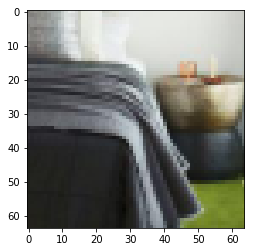

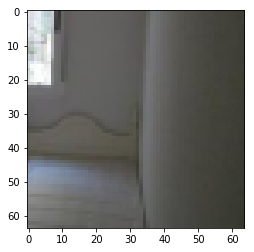

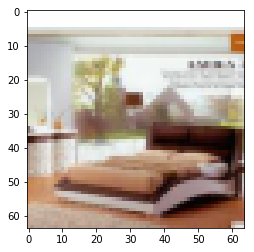

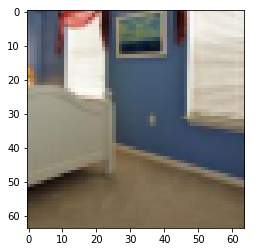

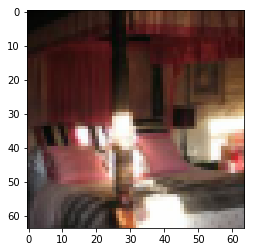

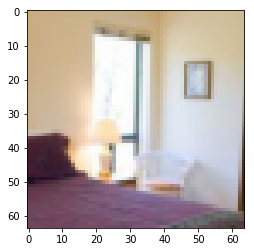

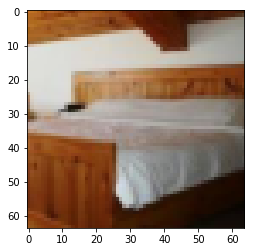

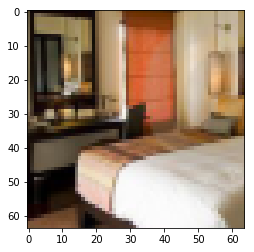

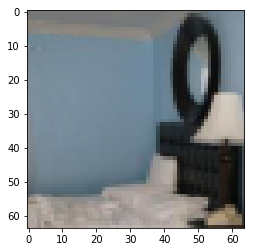

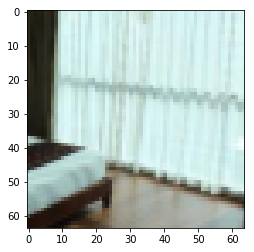

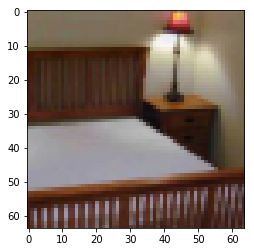

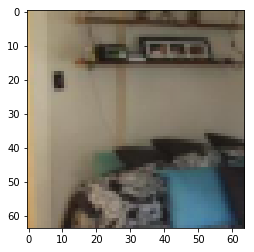

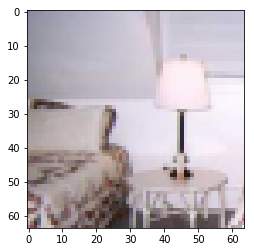

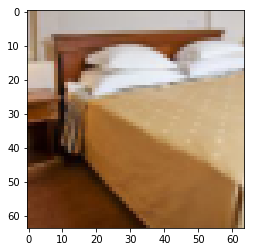

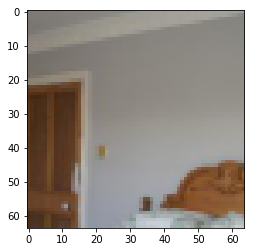

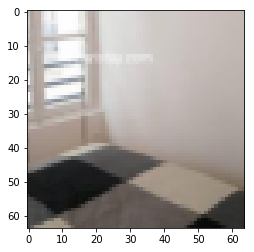

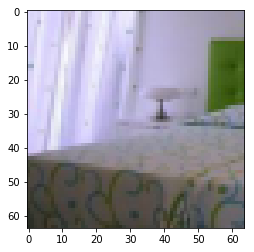

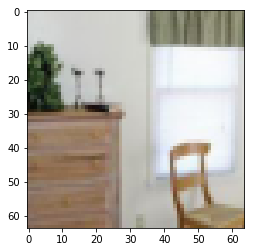

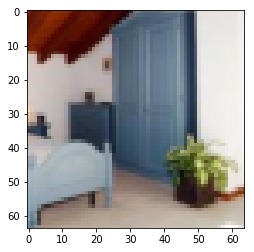

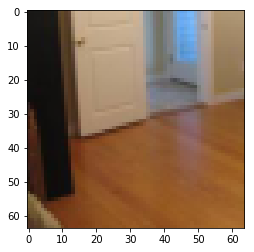

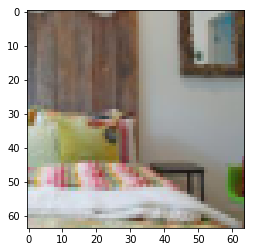

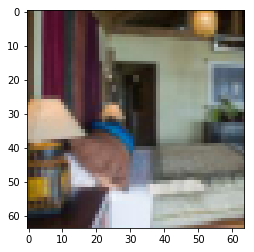

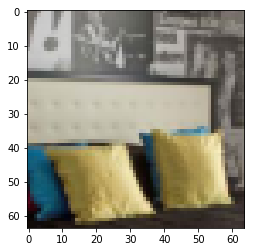

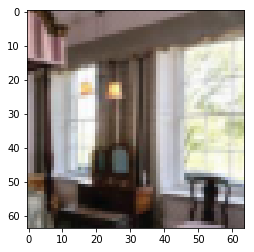

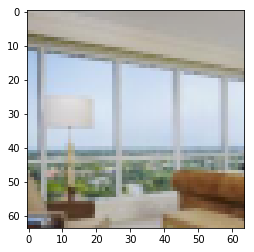

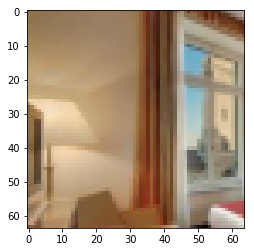

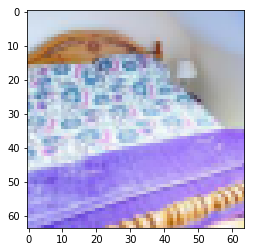

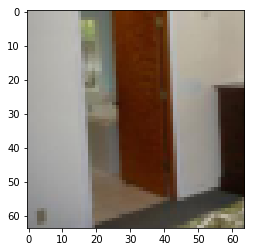

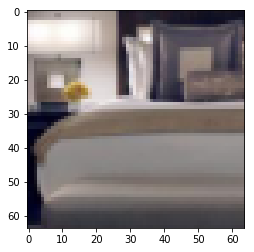

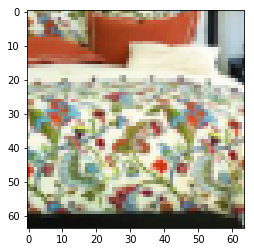

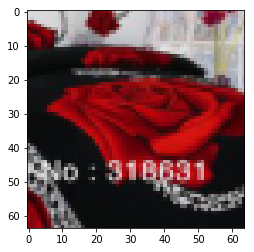

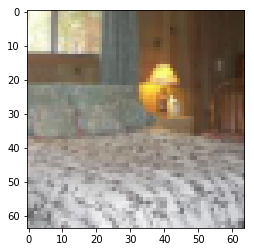

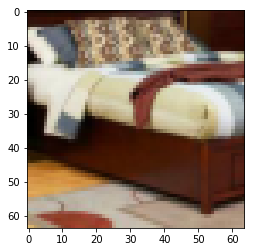

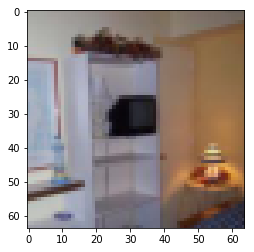

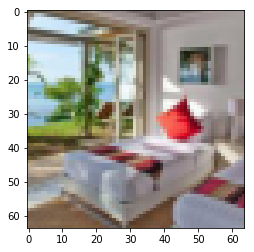

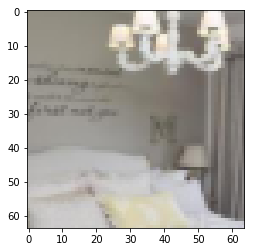

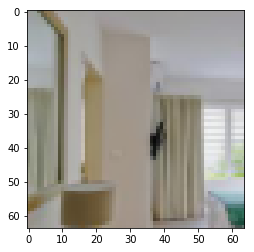

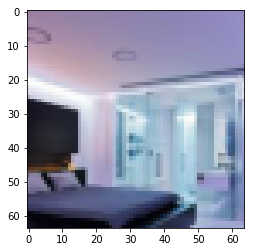

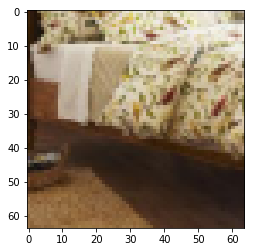

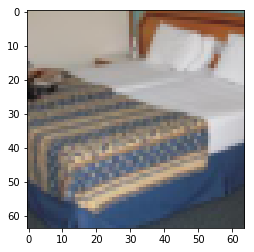

In [7]:
for i in range(40):
    plt.imshow(x[i])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


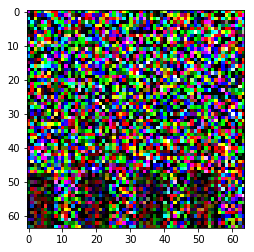

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


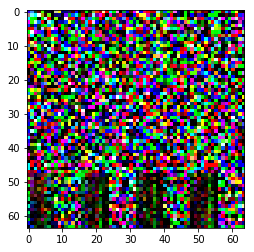

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


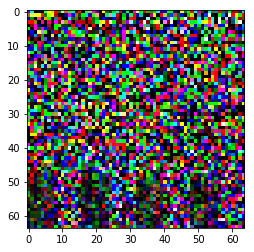

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


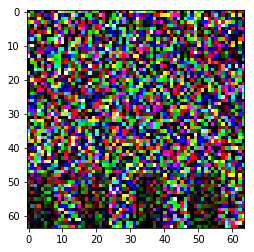

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


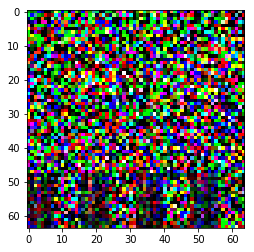

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


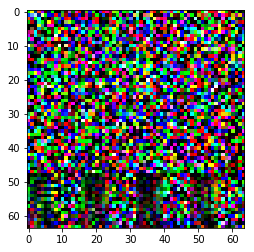

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


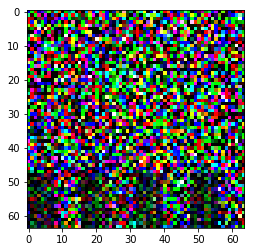

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


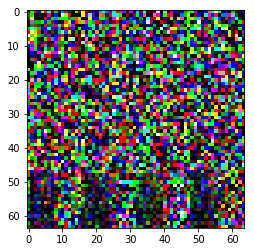

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


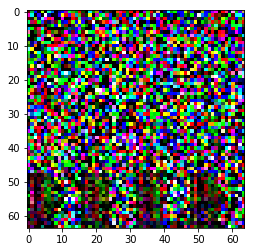

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


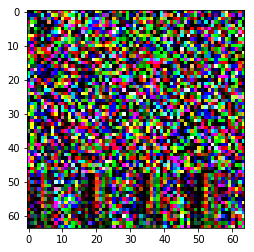

In [8]:
for i in range(10):
    plt.imshow(np.reshape(z[i], (64, 64, 3)))
    plt.show()

In [9]:
x = z[200]

In [10]:
tf.cast(tf.clip_by_value(tf.floor((x + .5)*256)*(256./256), 0, 255), 'uint8')

<tf.Tensor 'Cast:0' shape=(12288,) dtype=uint8>

In [11]:
v = np.clip(np.floor((x + .5)*256)*(256./256), 0, 255).astype('uint8')

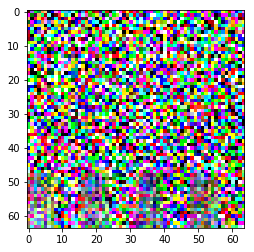

In [12]:
plt.imshow(np.reshape(v, (64, 64, 3)))

In [14]:
model.decode

AttributeError: module 'model' has no attribute 'decode'

In [1]:
import os
import sys
import time

import horovod.tensorflow as hvd
import numpy as np
import tensorflow as tf
import graphics
from utils import ResultLogger
import tfops as Z

In [2]:
def tensorflow_session():
    # Init session and params
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # Pin GPU to local rank (one GPU per process)
    config.gpu_options.visible_device_list = str(hvd.local_rank())
    sess = tf.Session(config=config)
    return sess

In [3]:
import signal
signal.signal(signal.SIGINT, lambda x, y: sys.exit(0))

import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--verbose", action='store_true', help="Verbose mode")
parser.add_argument("--restore_path", type=str, default='',
                    help="Location of checkpoint to restore")
parser.add_argument("--inference", action="store_true",
                    help="Use in inference mode")
parser.add_argument("--logdir", type=str,
                    default='./logs', help="Location to save logs")

# Dataset hyperparams:
parser.add_argument("--problem", type=str, default='cifar10',
                    help="Problem (mnist/cifar10/imagenet")
parser.add_argument("--category", type=str,
                    default='', help="LSUN category")
parser.add_argument("--data_dir", type=str, default='',
                    help="Location of data")
parser.add_argument("--dal", type=int, default=1,
                    help="Data augmentation level: 0=None, 1=Standard, 2=Extra")

# New dataloader params
parser.add_argument("--fmap", type=int, default=1,
                    help="# Threads for parallel file reading")
parser.add_argument("--pmap", type=int, default=16,
                    help="# Threads for parallel map")

# Optimization hyperparams:
parser.add_argument("--n_train", type=int,
                    default=50000, help="Train epoch size")
parser.add_argument("--n_test", type=int, default=-
                    1, help="Valid epoch size")
parser.add_argument("--n_batch_train", type=int,
                    default=64, help="Minibatch size")
parser.add_argument("--n_batch_test", type=int,
                    default=50, help="Minibatch size")
parser.add_argument("--n_batch_init", type=int, default=256,
                    help="Minibatch size for data-dependent init")
parser.add_argument("--optimizer", type=str,
                    default="adamax", help="adam or adamax")
parser.add_argument("--lr", type=float, default=0.001,
                    help="Base learning rate")
parser.add_argument("--beta1", type=float, default=.9, help="Adam beta1")
parser.add_argument("--polyak_epochs", type=float, default=1,
                    help="Nr of averaging epochs for Polyak and beta2")
parser.add_argument("--weight_decay", type=float, default=1.,
                    help="Weight decay. Switched off by default.")
parser.add_argument("--epochs", type=int, default=1000000,
                    help="Total number of training epochs")
parser.add_argument("--epochs_warmup", type=int,
                    default=10, help="Warmup epochs")
parser.add_argument("--epochs_full_valid", type=int,
                    default=50, help="Epochs between valid")
parser.add_argument("--gradient_checkpointing", type=int,
                    default=1, help="Use memory saving gradients")

# Model hyperparams:
parser.add_argument("--image_size", type=int,
                    default=-1, help="Image size")
parser.add_argument("--anchor_size", type=int, default=32,
                    help="Anchor size for deciding batch size")
parser.add_argument("--width", type=int, default=512,
                    help="Width of hidden layers")
parser.add_argument("--depth", type=int, default=32,
                    help="Depth of network")
parser.add_argument("--weight_y", type=float, default=0.00,
                    help="Weight of log p(y|x) in weighted loss")
parser.add_argument("--n_bits_x", type=int, default=8,
                    help="Number of bits of x")
parser.add_argument("--n_levels", type=int, default=3,
                    help="Number of levels")

# Synthesis/Sampling hyperparameters:
parser.add_argument("--n_sample", type=int, default=1,
                    help="minibatch size for sample")
parser.add_argument("--epochs_full_sample", type=int,
                    default=50, help="Epochs between full scale sample")

# Ablation
parser.add_argument("--learntop", action="store_true",
                    help="Learn spatial prior")
parser.add_argument("--ycond", action="store_true",
                    help="Use y conditioning")
parser.add_argument("--seed", type=int, default=0, help="Random seed")
parser.add_argument("--flow_permutation", type=int, default=2,
                    help="Type of flow. 0=reverse (realnvp), 1=shuffle, 2=invconv (ours)")
parser.add_argument("--flow_coupling", type=int, default=0,
                    help="Coupling type: 0=additive, 1=affine")

#hps = parser.parse_args('--inference --restore_path /data/datasets/glow/pretrained/lsun-rnvp-bdr/model_best_loss.ckpt --problem lsun_realnvp --category bedroom  --logdir logs_lsun_03272019/ --data_dir /data/datasets/glow/tfr/lsun_realnvp/ --image_size 64 --n_level 4 --depth 48 --flow_permutation 2 --flow_coupling 1 --seed 0 --n_bits_x 8'.split())
#hps = parser.parse_args('--inference --restore_path /data/datasets/glow/pretrained/lsun-rnvp-bdr/model_best_loss.ckpt --problem lsun_realnvp --category bedroom  --logdir logs_lsun_03272019/ --data_dir /data/datasets/glow/tfr/lsun_realnvp/ --image_size 64 --n_level 3 --depth 48 --flow_permutation 2 --flow_coupling 1 --seed 0 --n_bits_x 8'.split())
#hps = parser.parse_args('--inference --restore_path logs_cho_03282019/model_best_loss.ckpt --problem imagenet-oord --data_dir /root/tfr/imagenet-oord-tfr/ --logdir logs_cho_03282019 --n_level 4'.split())
hps = parser.parse_args('--inference --restore_path logs_cho_03282019/model_best_loss.ckpt --problem imagenet-oord --data_dir /root/tfr/imagenet-oord-tfr/ --logdir logs_cho_03282019 --image_size 64 --n_level 4 --depth 32 --flow_permutation 2 --flow_coupling 0 --seed 0 --n_bits_x 8'.split())

In [4]:
hps

Namespace(anchor_size=32, beta1=0.9, category='', dal=1, data_dir='/root/tfr/imagenet-oord-tfr/', depth=32, epochs=1000000, epochs_full_sample=50, epochs_full_valid=50, epochs_warmup=10, flow_coupling=0, flow_permutation=2, fmap=1, gradient_checkpointing=1, image_size=64, inference=True, learntop=False, logdir='logs_cho_03282019', lr=0.001, n_batch_init=256, n_batch_test=50, n_batch_train=64, n_bits_x=8, n_levels=4, n_sample=1, n_test=-1, n_train=50000, optimizer='adamax', pmap=16, polyak_epochs=1, problem='imagenet-oord', restore_path='logs_cho_03282019/model_best_loss.ckpt', seed=0, verbose=False, weight_decay=1.0, weight_y=0.0, width=512, ycond=False)

In [22]:
hps.n_y

1000

In [23]:
hps.local_batch_train

16

In [24]:
hps.local_batch_test

10

In [5]:
def get_data(hps, sess):
    if hps.image_size == -1:
        hps.image_size = {'mnist': 32, 'cifar10': 32, 'imagenet-oord': 64,
                          'imagenet': 256, 'celeba': 256, 'lsun_realnvp': 64, 'lsun': 256}[hps.problem]
    if hps.n_test == -1:
        hps.n_test = {'mnist': 10000, 'cifar10': 10000, 'imagenet-oord': 50000, 'imagenet': 50000,
                      'celeba': 3000, 'lsun_realnvp': 300*hvd.size(), 'lsun': 300*hvd.size()}[hps.problem]
    hps.n_y = {'mnist': 10, 'cifar10': 10, 'imagenet-oord': 1000,
               'imagenet': 1000, 'celeba': 1, 'lsun_realnvp': 1, 'lsun': 1}[hps.problem]
    if hps.data_dir == "":
        hps.data_dir = {'mnist': None, 'cifar10': None, 'imagenet-oord': '/root/tfr/imagenet-oord-tfr', 'imagenet': '/mnt/host/imagenet-tfr',
                        'celeba': '/root/tfr/celeba-tfr', 'lsun_realnvp': '/mnt/host/lsun_realnvp', 'lsun': '/mnt/host/lsun'}[hps.problem]

    if hps.problem == 'lsun_realnvp':
        hps.rnd_crop = True
    else:
        hps.rnd_crop = False

    if hps.category:
        hps.data_dir += ('/%s' % hps.category)

    # Use anchor_size to rescale batch size based on image_size
    s = hps.anchor_size
    hps.local_batch_train = hps.n_batch_train * \
        s * s // (hps.image_size * hps.image_size)
    hps.local_batch_test = {64: 50, 32: 25, 16: 10, 8: 5, 4: 2, 2: 2, 1: 1}[
        hps.local_batch_train]  # round down to closest divisor of 50
    hps.local_batch_init = hps.n_batch_init * \
        s * s // (hps.image_size * hps.image_size)

    print("Rank {} Batch sizes Train {} Test {} Init {}".format(
        hvd.rank(), hps.local_batch_train, hps.local_batch_test, hps.local_batch_init))

    if hps.problem in ['imagenet-oord', 'imagenet', 'celeba', 'lsun_realnvp', 'lsun']:
        hps.direct_iterator = True
        import data_loaders.get_data as v
        train_iterator, test_iterator, data_init = \
            v.get_data(sess, hps.data_dir, hvd.size(), hvd.rank(), hps.pmap, hps.fmap, hps.local_batch_train,
                       hps.local_batch_test, hps.local_batch_init, hps.image_size, hps.rnd_crop)

    elif hps.problem in ['mnist', 'cifar10']:
        hps.direct_iterator = False
        import data_loaders.get_mnist_cifar as v
        train_iterator, test_iterator, data_init = \
            v.get_data(hps.problem, hvd.size(), hvd.rank(), hps.dal, hps.local_batch_train,
                       hps.local_batch_test, hps.local_batch_init, hps.image_size)

    else:
        raise Exception()

    return train_iterator, test_iterator, data_init


In [6]:
# Get number of training and validation iterations
def get_its(hps):
    # These run for a fixed amount of time. As anchored batch is smaller, we've actually seen fewer examples
    train_its = int(np.ceil(hps.n_train / (hps.n_batch_train * hvd.size())))
    test_its = int(np.ceil(hps.n_test / (hps.n_batch_train * hvd.size())))
    train_epoch = train_its * hps.n_batch_train * hvd.size()

    # Do a full validation run
    if hvd.rank() == 0:
        print(hps.n_test, hps.local_batch_test, hvd.size())
    assert hps.n_test % (hps.local_batch_test * hvd.size()) == 0
    full_test_its = hps.n_test // (hps.local_batch_test * hvd.size())

    if hvd.rank() == 0:
        print("Train epoch size: " + str(train_epoch))
    return train_its, test_its, full_test_its

In [25]:
def init_visualizations(hps, model, logdir):

    def sample_batch(y, eps):
        n_batch = hps.local_batch_test
        xs = []
        for i in range(int(np.ceil(len(eps) / n_batch))):
            xs.append(model.sample(
                y[i*n_batch:i*n_batch + n_batch], eps[i*n_batch:i*n_batch + n_batch]))
        return np.concatenate(xs)

    def draw_samples(epoch):
        if hvd.rank() != 0:
            return

        rows = 10 if hps.image_size <= 64 else 4
        cols = rows
        n_batch = rows*cols
        y = np.asarray([_y % hps.n_y for _y in (
            list(range(cols)) * rows)], dtype='int32')

        # temperatures = [0., .25, .5, .626, .75, .875, 1.] #previously
        temperatures = [0., .25, .5, .6, .7, .8, .9, 1.]

        x_samples = []
        x_samples.append(sample_batch(y, [.0]*n_batch))
        x_samples.append(sample_batch(y, [.25]*n_batch))
        x_samples.append(sample_batch(y, [.5]*n_batch))
        x_samples.append(sample_batch(y, [.6]*n_batch))
        x_samples.append(sample_batch(y, [.7]*n_batch))
        x_samples.append(sample_batch(y, [.8]*n_batch))
        x_samples.append(sample_batch(y, [.9] * n_batch))
        x_samples.append(sample_batch(y, [1.]*n_batch))
        # previously: 0, .25, .5, .625, .75, .875, 1.

        for i in range(len(x_samples)):
            x_sample = np.reshape(
                x_samples[i], (n_batch, hps.image_size, hps.image_size, 3))
            graphics.save_raster(x_sample, logdir +
                                 'epoch_{}_sample_{}.png'.format(epoch, i))

    return draw_samples

In [8]:
# Initialize Horovod.
hvd.init()

# Create tensorflow session
sess = tensorflow_session()

# Download and load dataset.
tf.set_random_seed(hvd.rank() + hvd.size() * hps.seed)
np.random.seed(hvd.rank() + hvd.size() * hps.seed)

# Get data and set train_its and valid_its
train_iterator, test_iterator, data_init = get_data(hps, sess)
hps.train_its, hps.test_its, hps.full_test_its = get_its(hps)

# Create log dir
logdir = os.path.abspath(hps.logdir) + "/"
if not os.path.exists(logdir):
    os.mkdir(logdir)

# Create model
import model
model = model.model(sess, hps, train_iterator, test_iterator, data_init)

# Initialize visualization functions
visualise = init_visualizations(hps, model, logdir)

Rank 0 Batch sizes Train 16 Test 10 Init 64
50000 10 1
Train epoch size: 50048
Creating pad 1_1_34_34
Creating pad 1_1_18_18
Creating pad 1_1_10_10
Creating pad 1_1_6_6
INFO:tensorflow:Restoring parameters from logs_cho_03282019/model_best_loss.ckpt
m.restore
[<tf.Tensor 'model_3/pool0/truediv_1:0' shape=(?, 32, 32, 6) dtype=float32>, <tf.Tensor 'model_3/pool1/truediv_1:0' shape=(?, 16, 16, 12) dtype=float32>, <tf.Tensor 'model_3/pool2/truediv_1:0' shape=(?, 8, 8, 24) dtype=float32>, <tf.Tensor 'model_3/truediv_2:0' shape=(?, 4, 4, 96) dtype=float32>]
0 Tensor("model_3/pool0/truediv_1:0", shape=(?, 32, 32, 6), dtype=float32)
1 Tensor("model_3/pool1/truediv_1:0", shape=(?, 16, 16, 12), dtype=float32)
2 Tensor("model_3/pool2/truediv_1:0", shape=(?, 8, 8, 24), dtype=float32)
3 Tensor("model_3/truediv_2:0", shape=(?, 4, 4, 96), dtype=float32)


In [9]:
def infer_visualise(sess, model, hps, iterator, visualise):
    # Example of using model in inference mode. Load saved model using hps.restore_path
    # Can provide x, y from files instead of dataset iterator
    # If model is uncondtional, always pass y = np.zeros([bs], dtype=np.int32)
    
    visualise(998)

    if hps.direct_iterator:
        iterator = iterator.get_next()

    xs = []
    zs = []
    for it in range(hps.full_test_its):
        if hps.direct_iterator:
            # replace with x, y, attr if you're getting CelebA attributes, also modify get_data
            x, y = sess.run(iterator)
        else:
            x, y = iterator()

        z = model.encode(x, y)
        x = model.decode(y, z)
        xs.append(x)
        zs.append(z)

    visualise(999)

    x = np.concatenate(xs, axis=0)
    z = np.concatenate(zs, axis=0)
    np.save('logs/x.npy', x)
    np.save('logs/z.npy', z)
    return zs

In [10]:
#infer_visualise(sess, model, hps, test_iterator, visualise)

In [26]:
def sample_batch(y, eps):
    n_batch = hps.local_batch_test
    xs = []
    for i in range(int(np.ceil(len(eps) / n_batch))):
        xs.append(model.sample(
            y[i*n_batch:i*n_batch + n_batch], eps[i*n_batch:i*n_batch + n_batch]))
    return np.concatenate(xs)

In [27]:
rows = 10 if hps.image_size <= 64 else 4
cols = rows
n_batch = rows*cols
y = np.asarray([_y % hps.n_y for _y in (
    list(range(cols)) * rows)], dtype='int32')

# temperatures = [0., .25, .5, .626, .75, .875, 1.] #previously
temperatures = [0., .25, .5, .6, .7, .8, .9, 1.]

In [28]:
y.shape

(100,)

In [29]:
x_samples = []

In [30]:
x_samples.append(sample_batch(y, [.0]*n_batch))
x_samples.append(sample_batch(y, [.25]*n_batch))
x_samples.append(sample_batch(y, [.5]*n_batch))
x_samples.append(sample_batch(y, [.6]*n_batch))
x_samples.append(sample_batch(y, [.7]*n_batch))
x_samples.append(sample_batch(y, [.8]*n_batch))
x_samples.append(sample_batch(y, [.9] * n_batch))
x_samples.append(sample_batch(y, [1.]*n_batch))

_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
_y
[0 1 2 3 4 5 6 7 8 9]
_eps_std
[0.25, 0.25, 0.25, 0.

In [34]:
y

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [35]:
n_batch

100

In [31]:
s1 = sample_batch(y, [1.]*n_batch)

In [32]:
prefix = 790
for i in range(len(x_samples)):
    x_sample = np.reshape(
        x_samples[i], (n_batch, hps.image_size, hps.image_size, 3))
    graphics.save_raster(x_sample, logdir +
                         '{}_sample_{}.png'.format(prefix, i))

In [18]:
hps.n_bits_x

8

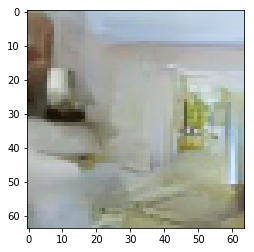

In [22]:
plt.imshow(s1[9])

In [37]:
if hps.direct_iterator:
    iterator = test_iterator.get_next()

xs = []
zs = []

In [38]:
iterator

(<tf.Tensor 'IteratorGetNext_3:0' shape=(?, 64, 64, 3) dtype=uint8>,
 <tf.Tensor 'IteratorGetNext_3:1' shape=(?,) dtype=int32>)

In [39]:
hps.full_test_its

30

In [41]:
x, y = sess.run(iterator)

In [19]:
x = np.load('logs/x.npy')
z = np.load('logs/z.npy')

In [20]:
x.shape

(300, 64, 64, 3)

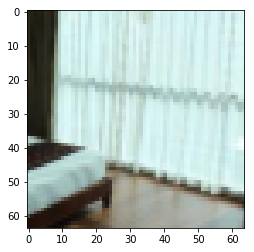

In [21]:
plt.imshow(x[9])

In [48]:
z = model.encode(x, y)

In [20]:
z.shape

NameError: name 'z' is not defined

In [25]:
z[:10].shape

(10, 12288)

In [31]:
z1 = np.ones((1, 12288))

In [48]:
def prior(name, y_onehot, hps):

    with tf.variable_scope(name):
        n_z = hps.top_shape[-1]

        h = tf.zeros([tf.shape(y_onehot)[0]]+hps.top_shape[:2]+[2*n_z])
        if hps.learntop:
            h = Z.conv2d_zeros('p', h, 2*n_z)
        if hps.ycond:
            h += tf.reshape(Z.linear_zeros("y_emb", y_onehot,
                                           2*n_z), [-1, 1, 1, 2 * n_z])

        pz = Z.gaussian_diag(h[:, :, :, :n_z], h[:, :, :, n_z:])

    def logp(z1):
        objective = pz.logp(z1)
        return objective

    def sample(eps=None, eps_std=None):
        if eps is not None:
            # Already sampled eps. Don't use eps_std
            z = pz.sample2(eps)
        elif eps_std is not None:
            # Sample with given eps_std
            z = pz.sample2(pz.eps * tf.reshape(eps_std, [-1, 1, 1, 1]))
        else:
            # Sample normally
            z = pz.sample

        return z

    def eps(z1):
        return pz.get_eps(z1)

    return logp, sample, eps

In [49]:
y_onehot = tf.cast(tf.one_hot(y, hps.n_y, 1, 0), 'float32')

In [53]:
_, sample, _ = prior("prior", y_onehot, hps)

In [58]:
z = sample(eps_std=[1.0] * 100)
print(z.shape)

(100, 8, 8, 48)


In [60]:
def codec(hps):

    def encoder(z, objective):
        eps = []
        for i in range(hps.n_levels):
            z, objective = revnet2d(str(i), z, objective, hps)
            if i < hps.n_levels-1:
                z, objective, _eps = split2d("pool"+str(i), z, objective=objective)
                eps.append(_eps)
        return z, objective, eps

    def decoder(z, eps=[None]*hps.n_levels, eps_std=None):
        for i in reversed(range(hps.n_levels)):
            if i < hps.n_levels-1:
                z = split2d_reverse("pool"+str(i), z, eps=eps[i], eps_std=eps_std)
            z, _ = revnet2d(str(i), z, 0, hps, reverse=True)

        return z

    return encoder, decoder

In [63]:
def revnet2d(name, z, logdet, hps, reverse=False):
    with tf.variable_scope(name):
        if not reverse:
            for i in range(hps.depth):
                z, logdet = checkpoint(z, logdet)
                z, logdet = revnet2d_step(str(i), z, logdet, hps, reverse)
            z, logdet = checkpoint(z, logdet)
        else:
            for i in reversed(range(hps.depth)):
                z, logdet = revnet2d_step(str(i), z, logdet, hps, reverse)
    return z, logdet

# Simpler, new version
def revnet2d_step(name, z, logdet, hps, reverse):
    with tf.variable_scope(name):

        shape = Z.int_shape(z)
        n_z = shape[3]
        assert n_z % 2 == 0

        if not reverse:

            z, logdet = Z.actnorm("actnorm", z, logdet=logdet)

            if hps.flow_permutation == 0:
                z = Z.reverse_features("reverse", z)
            elif hps.flow_permutation == 1:
                z = Z.shuffle_features("shuffle", z)
            elif hps.flow_permutation == 2:
                z, logdet = invertible_1x1_conv("invconv", z, logdet)
            else:
                raise Exception()

            z1 = z[:, :, :, :n_z // 2]
            z2 = z[:, :, :, n_z // 2:]

            if hps.flow_coupling == 0:
                z2 += f("f1", z1, hps.width)
            elif hps.flow_coupling == 1:
                h = f("f1", z1, hps.width, n_z)
                shift = h[:, :, :, 0::2]
                # scale = tf.exp(h[:, :, :, 1::2])
                scale = tf.nn.sigmoid(h[:, :, :, 1::2] + 2.)
                z2 += shift
                z2 *= scale
                logdet += tf.reduce_sum(tf.log(scale), axis=[1, 2, 3])
            else:
                raise Exception()

            z = tf.concat([z1, z2], 3)

        else:

            z1 = z[:, :, :, :n_z // 2]
            z2 = z[:, :, :, n_z // 2:]

            if hps.flow_coupling == 0:
                z2 -= f("f1", z1, hps.width)
            elif hps.flow_coupling == 1:
                h = f("f1", z1, hps.width, n_z)
                shift = h[:, :, :, 0::2]
                # scale = tf.exp(h[:, :, :, 1::2])
                scale = tf.nn.sigmoid(h[:, :, :, 1::2] + 2.)
                z2 /= scale
                z2 -= shift
                logdet -= tf.reduce_sum(tf.log(scale), axis=[1, 2, 3])
            else:
                raise Exception()

            z = tf.concat([z1, z2], 3)

            if hps.flow_permutation == 0:
                z = Z.reverse_features("reverse", z, reverse=True)
            elif hps.flow_permutation == 1:
                z = Z.shuffle_features("shuffle", z, reverse=True)
            elif hps.flow_permutation == 2:
                z, logdet = invertible_1x1_conv(
                    "invconv", z, logdet, reverse=True)
            else:
                raise Exception()

            z, logdet = Z.actnorm("actnorm", z, logdet=logdet, reverse=True)

    return z, logdet

In [65]:
def f(name, h, width, n_out=None):
    n_out = n_out or int(h.get_shape()[3])
    with tf.variable_scope(name):
        h = tf.nn.relu(Z.conv2d("l_1", h, width))
        h = tf.nn.relu(Z.conv2d("l_2", h, width, filter_size=[1, 1]))
        h = Z.conv2d_zeros("l_last", h, n_out)
    return h

In [67]:
def invertible_1x1_conv(name, z, logdet, reverse=False):

    if True:  # Set to "False" to use the LU-decomposed version

        with tf.variable_scope(name):

            shape = Z.int_shape(z)
            w_shape = [shape[3], shape[3]]

            # Sample a random orthogonal matrix:
            w_init = np.linalg.qr(np.random.randn(
                *w_shape))[0].astype('float32')

            w = tf.get_variable("W", dtype=tf.float32, initializer=w_init)

            # dlogdet = tf.linalg.LinearOperator(w).log_abs_determinant() * shape[1]*shape[2]
            dlogdet = tf.cast(tf.log(abs(tf.matrix_determinant(
                tf.cast(w, 'float64')))), 'float32') * shape[1]*shape[2]

            if not reverse:

                _w = tf.reshape(w, [1, 1] + w_shape)
                z = tf.nn.conv2d(z, _w, [1, 1, 1, 1],
                                 'SAME', data_format='NHWC')
                logdet += dlogdet

                return z, logdet
            else:

                _w = tf.matrix_inverse(w)
                _w = tf.reshape(_w, [1, 1]+w_shape)
                z = tf.nn.conv2d(z, _w, [1, 1, 1, 1],
                                 'SAME', data_format='NHWC')
                logdet -= dlogdet

                return z, logdet

    else:

        # LU-decomposed version
        shape = Z.int_shape(z)
        with tf.variable_scope(name):

            dtype = 'float64'

            # Random orthogonal matrix:
            import scipy
            np_w = scipy.linalg.qr(np.random.randn(shape[3], shape[3]))[
                0].astype('float32')

            np_p, np_l, np_u = scipy.linalg.lu(np_w)
            np_s = np.diag(np_u)
            np_sign_s = np.sign(np_s)
            np_log_s = np.log(abs(np_s))
            np_u = np.triu(np_u, k=1)

            p = tf.get_variable("P", initializer=np_p, trainable=False)
            l = tf.get_variable("L", initializer=np_l)
            sign_s = tf.get_variable(
                "sign_S", initializer=np_sign_s, trainable=False)
            log_s = tf.get_variable("log_S", initializer=np_log_s)
            # S = tf.get_variable("S", initializer=np_s)
            u = tf.get_variable("U", initializer=np_u)

            p = tf.cast(p, dtype)
            l = tf.cast(l, dtype)
            sign_s = tf.cast(sign_s, dtype)
            log_s = tf.cast(log_s, dtype)
            u = tf.cast(u, dtype)

            w_shape = [shape[3], shape[3]]

            l_mask = np.tril(np.ones(w_shape, dtype=dtype), -1)
            l = l * l_mask + tf.eye(*w_shape, dtype=dtype)
            u = u * np.transpose(l_mask) + tf.diag(sign_s * tf.exp(log_s))
            w = tf.matmul(p, tf.matmul(l, u))

            if True:
                u_inv = tf.matrix_inverse(u)
                l_inv = tf.matrix_inverse(l)
                p_inv = tf.matrix_inverse(p)
                w_inv = tf.matmul(u_inv, tf.matmul(l_inv, p_inv))
            else:
                w_inv = tf.matrix_inverse(w)

            w = tf.cast(w, tf.float32)
            w_inv = tf.cast(w_inv, tf.float32)
            log_s = tf.cast(log_s, tf.float32)

            if not reverse:

                w = tf.reshape(w, [1, 1] + w_shape)
                z = tf.nn.conv2d(z, w, [1, 1, 1, 1],
                                 'SAME', data_format='NHWC')
                logdet += tf.reduce_sum(log_s) * (shape[1]*shape[2])

                return z, logdet
            else:

                w_inv = tf.reshape(w_inv, [1, 1]+w_shape)
                z = tf.nn.conv2d(
                    z, w_inv, [1, 1, 1, 1], 'SAME', data_format='NHWC')
                logdet -= tf.reduce_sum(log_s) * (shape[1]*shape[2])

                return z, logdet

In [61]:
encoder, decoder = codec(hps)

In [68]:
z = decoder(z, eps_std=[1.0] * 100)
print(z.shape)

ValueError: Variable 2/47/f1/l_1/W already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/root/github/glow/tfops.py", line 247, in conv2d
    initializer=default_initializer())
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 183, in func_with_args
    return func(*args, **current_args)
  File "<ipython-input-65-65717e2846b1>", line 4, in f
    h = tf.nn.relu(Z.conv2d("l_1", h, width))


In [44]:
#x_d = model.decode(y, z)
#x_d = model.decode([0] * 1, z[:1])
x_d = model.decode([0] * 1, z[:2])

eps
[array([[[[ 7.07948506e-01, -1.91636935e-01,  1.89595807e+00,
          -2.07482433e+00,  1.58460587e-01, -8.73210430e-01],
         [ 1.27777410e+00,  2.60766864e-01, -2.98061132e-01,
          -5.32765567e-01,  1.02478933e+00, -9.47827160e-01],
         [-4.76171188e-02,  3.38468760e-01,  6.45070255e-01,
           1.22415197e+00,  1.18368018e+00,  5.88834226e-01],
         ...,
         [ 1.08730519e+00, -1.80709258e-01, -5.74886143e-01,
           1.01259351e+00,  3.37353677e-01, -9.99787331e-01],
         [ 2.80599743e-01,  1.52964437e+00,  1.05728388e+00,
           5.85732639e-01,  3.29582572e-01, -7.85553038e-01],
         [ 1.38472509e+00,  2.86440820e-01, -1.23024836e-01,
           1.73227385e-01,  1.47970450e+00, -2.27346525e-01]],

        [[ 6.78432807e-02,  2.11789638e-01,  1.74898982e-01,
          -5.64055741e-01, -1.47262871e+00,  6.96381629e-02],
         [ 8.27289104e-01, -4.55657959e-01,  5.35299862e-03,
          -5.12738645e-01, -2.10028529e+00,  1.13818324e+

In [45]:
x_d[0]

array([[[131, 130, 125],
        [140, 139, 134],
        [147, 147, 142],
        ...,
        [206, 207, 202],
        [205, 206, 201],
        [202, 203, 197]],

       [[131, 130, 127],
        [128, 127, 124],
        [134, 133, 130],
        ...,
        [206, 207, 202],
        [205, 206, 201],
        [202, 204, 197]],

       [[140, 139, 136],
        [141, 140, 138],
        [136, 135, 133],
        ...,
        [206, 207, 202],
        [205, 206, 201],
        [202, 204, 198]],

       ...,

       [[ 33,  32,  27],
        [ 34,  33,  28],
        [ 33,  32,  27],
        ...,
        [114, 133,  42],
        [113, 131,  41],
        [114, 131,  38]],

       [[ 33,  32,  27],
        [ 34,  33,  28],
        [ 33,  32,  27],
        ...,
        [112, 131,  41],
        [106, 125,  35],
        [110, 125,  39]],

       [[ 32,  32,  26],
        [ 34,  33,  28],
        [ 33,  33,  27],
        ...,
        [106, 125,  36],
        [103, 121,  33],
        [104, 119,  37]]

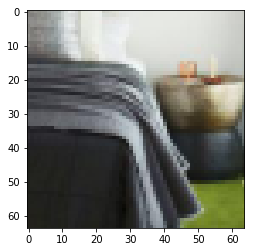

In [46]:
plt.imshow(x_d[0])

In [34]:
def unflatten_eps(feps):
    index = 0
    eps = []
    bs = feps.shape[0]
    for shape in eps_shapes:
        eps.append(np.reshape(feps[:, index: index+np.prod(shape)], (bs, *shape)))
        index += np.prod(shape)
    return eps

In [57]:
unflatten_eps(z)

NameError: name 'eps_shapes' is not defined